In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DATA_PATH = 'transcriptomic'

c:\Users\giuli\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
adata = sc.read(DATA_PATH)
adata

c:\Users\giuli\anaconda3\lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 250920 × 37944
    obs: 'dataset', 'disease', 'cell_type', 'sample', 'patient_id', 'time', 'cell_types_labels', 'patient', 'MS/HC'
    var: 'gene_ids', 'feature_types'

In [3]:
adata.obs.head()

,dataset,disease,cell_type,sample,patient_id,time,cell_types_labels,patient,MS/HC
AAACCCAAGACTGTTC-1,GSE239626,MS,PBMC,GSM7669046,N1,J0,T cells,NaN,MS
AAACCCAAGGATCATA-1,GSE239626,MS,PBMC,GSM7669046,N1,J0,T cells,NaN,MS
AAACCCAGTTATTCTC-1,GSE239626,MS,PBMC,GSM7669046,N1,J0,B cells,NaN,MS
AAACCCATCATGAGGG-1,GSE239626,MS,PBMC,GSM7669046,N1,J0,T cells,NaN,MS
AAACGAAAGCCAGTAG-1,GSE239626,MS,PBMC,GSM7669046,N1,J0,B cells,NaN,MS


In [4]:
adata.obs.describe()

,dataset,disease,cell_type,sample,patient_id,time,cell_types_labels,patient,MS/HC
count,250920,250920,250920,140355,169641,72317,250920,178603,250920
unique,3,6,2,39,16,2,19,23,2
top,GSE194078,MS,PBMC,GSM4104138,KSH,M3,T cells,GSM5827380,MS
freq,110565,151730,177189,7819,22578,37203,193689,22578,151730


In [5]:
adata.X

<250920x37944 sparse matrix of type '<class 'numpy.float64'>'
	with 385236280 stored elements in Compressed Sparse Row format>

In [6]:
adata.var.describe()

,gene_ids,feature_types
count,37944,37944
unique,37944,1
top,ENSG00000243485,Gene Expression
freq,1,37944


### Preproc

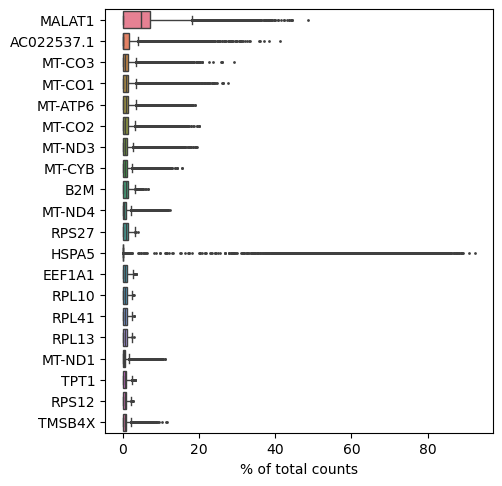

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [8]:
# basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

c:\Users\giuli\anaconda3\lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [9]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

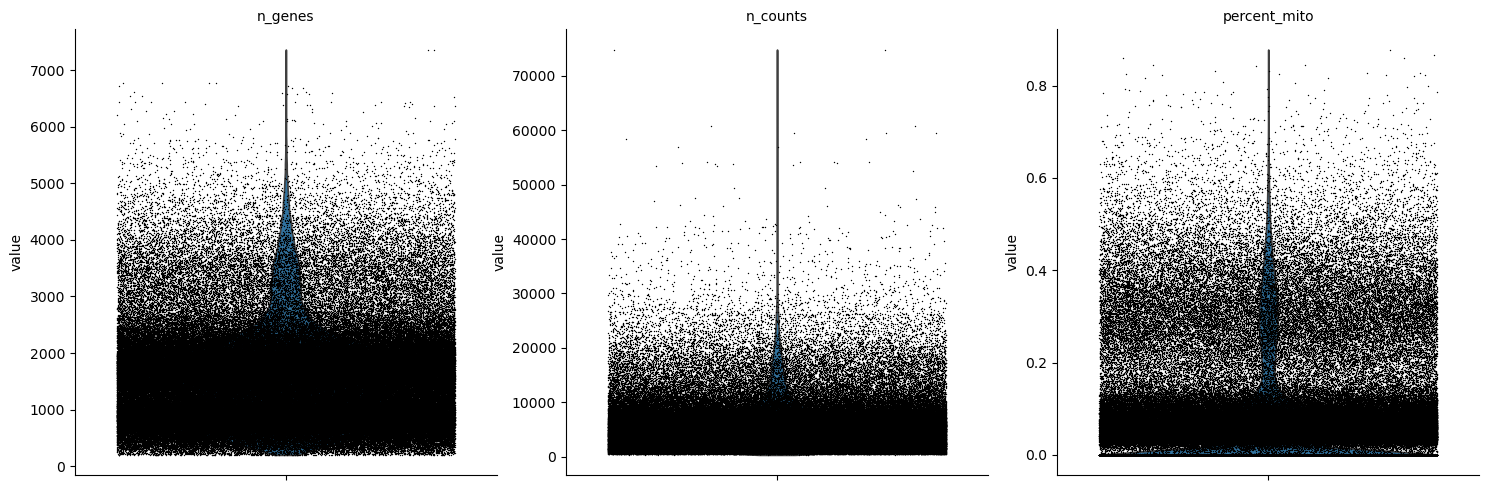

In [10]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0.4, multi_panel=True)

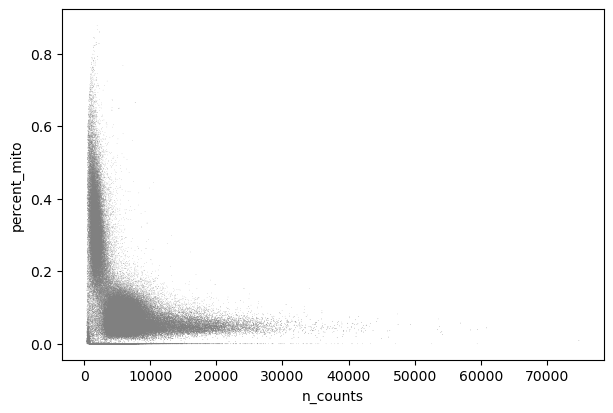

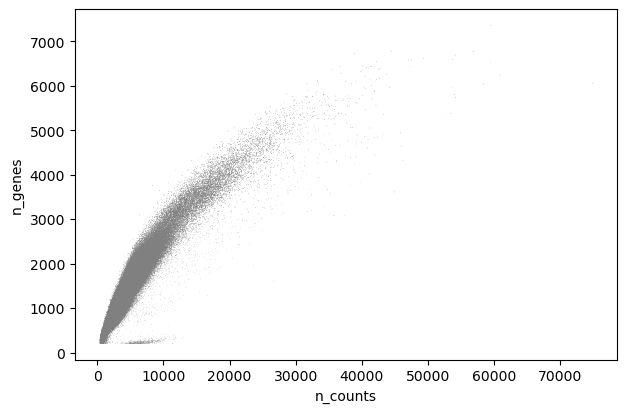

In [11]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [12]:
adata # initial dataset shape: n_obs × n_vars = 250920 × 37944

AnnData object with n_obs × n_vars = 247976 × 33427
    obs: 'dataset', 'disease', 'cell_type', 'sample', 'patient_id', 'time', 'cell_types_labels', 'patient', 'MS/HC', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'

In [13]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

Identify highly-variable genes.

In [14]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

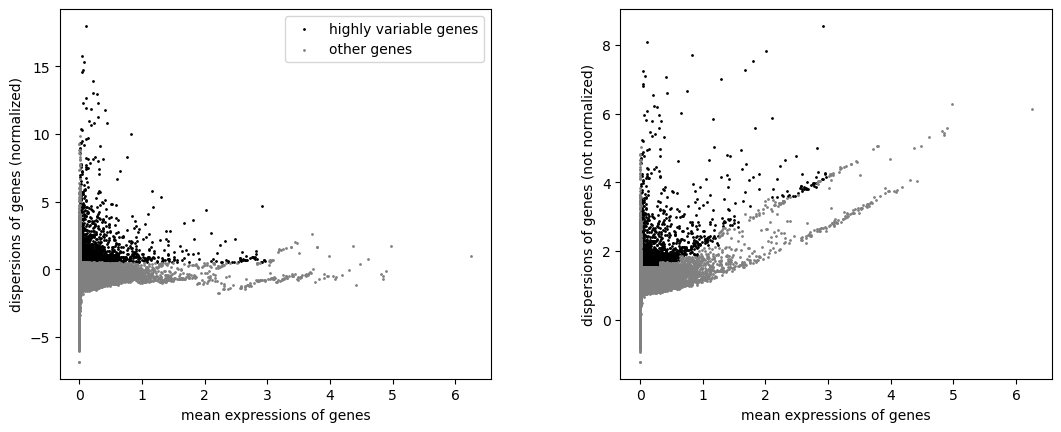

In [15]:
sc.pl.highly_variable_genes(adata)

In [16]:
adata = adata[:, adata.var.highly_variable] # filtering

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [17]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

c:\Users\giuli\anaconda3\lib\site-packages\scanpy\preprocessing\_simple.py:641: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [18]:
sc.pp.scale(adata, max_value=10)

### PCA

In [19]:
sc.tl.pca(adata, svd_solver='arpack')

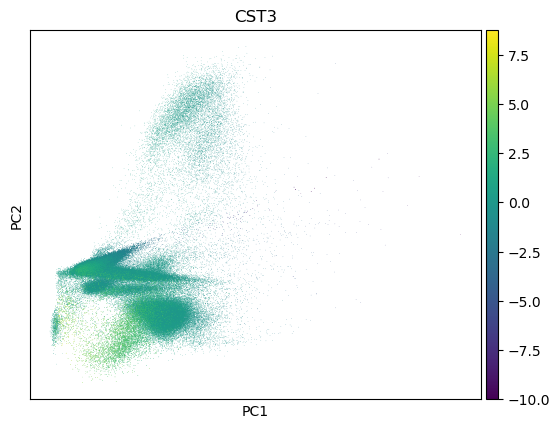

In [20]:
sc.pl.pca(adata, color='CST3')

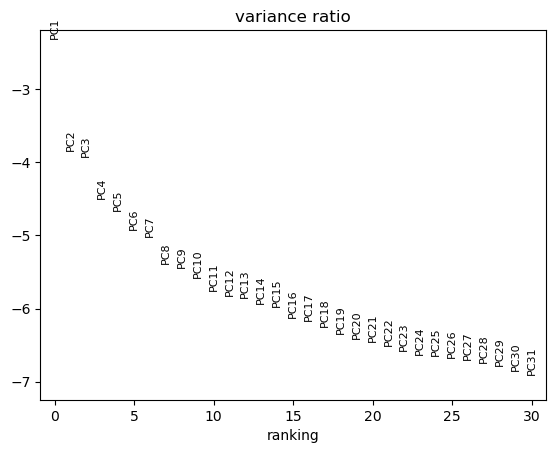

In [21]:
sc.pl.pca_variance_ratio(adata, log=True)

### Save results

In [22]:
adata

AnnData object with n_obs × n_vars = 247976 × 2789
    obs: 'dataset', 'disease', 'cell_type', 'sample', 'patient_id', 'time', 'cell_types_labels', 'patient', 'MS/HC', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [23]:
adata.write('write/transcriptomic_preproc.h5ad')

### Plots

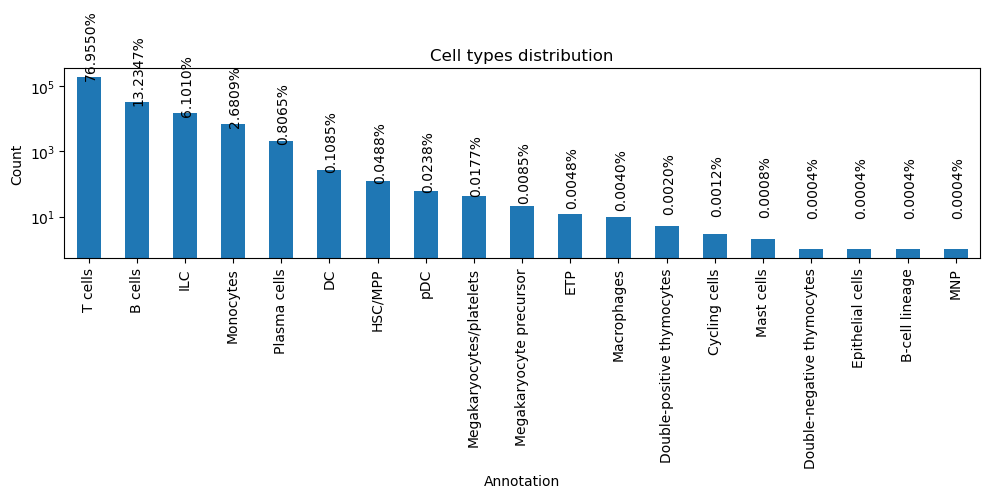

In [24]:
plt.figure(figsize=(10, 5))
ax = plt.gca()
adata.obs['cell_types_labels'].value_counts().plot(kind='bar', ax=ax)
total= len(adata.obs['cell_types_labels'])
for p in ax.patches:
    percentage = '{:.4f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_y() + p.get_height() + 10
    plt.annotate(percentage, (x, y), rotation=90)
plt.xticks(rotation=90)
plt.yscale('log')
plt.title('Cell types distribution')
plt.xlabel('Annotation')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

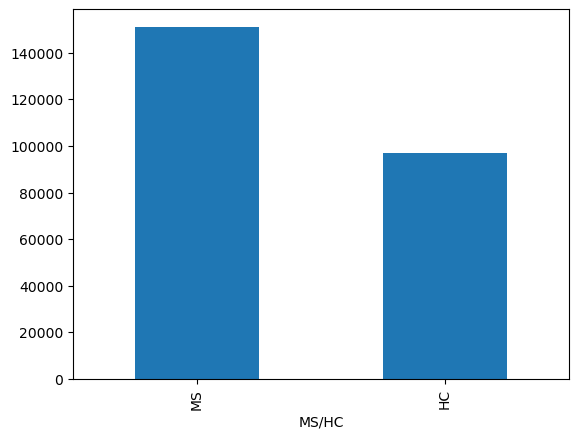

In [46]:
adata.obs['MS/HC'].value_counts().plot(kind='bar');

C:\Users\giuli\AppData\Local\Temp\ipykernel_21136\3577199415.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_counts = adata.obs.groupby(['cell_types_labels', 'MS/HC']).size().unstack(fill_value=0)


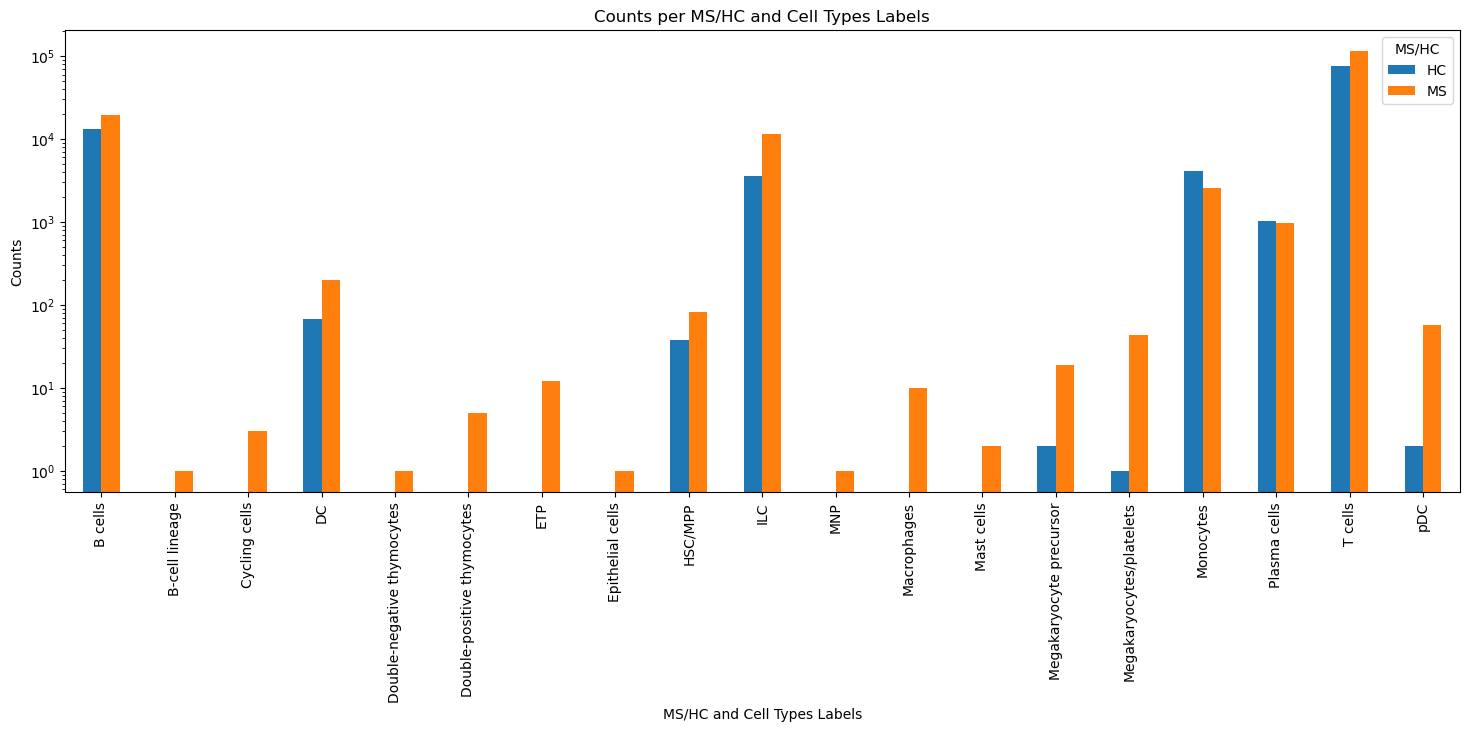

In [51]:
grouped_counts = adata.obs.groupby(['cell_types_labels', 'MS/HC']).size().unstack(fill_value=0) 
# n_genes, percent_mito, n_counts

grouped_counts.plot(kind='bar', stacked=False, logy=True, figsize=(18, 6))
plt.title('Counts per MS/HC and Cell Types Labels')
plt.xlabel('MS/HC and Cell Types Labels')
plt.ylabel('Counts')
plt.show()